# Microsoft (MSFT) Cleaning and Exploration

This notebook downloads the specified Kaggle dataset, applies a repeatable cleaning pipeline, generates diagnostic visualizations, and exports the processed data as a CSV file ready for AI forecasting.


In [1]:
import json
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")


/Users/sofnb25/Documents/MS34/MSA34 - Python/Project/demo_python_basic/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_dataset(dataset_id: str) -> Path:
    """Download a Kaggle dataset using kagglehub and return the download directory."""
    download_path = Path(kagglehub.dataset_download(dataset_id))
    print(f"Dataset downloaded to: {download_path}")
    return download_path

def select_csv_file(download_path: Path, search_terms: list[str]) -> Path:
    """Select the most relevant CSV file inside the dataset directory."""
    csv_files = sorted(download_path.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files were found in the downloaded dataset directory.")

    search_terms_lower = [term.lower() for term in search_terms]
    for csv_file in csv_files:
        filename = csv_file.name.lower()
        if any(term in filename for term in search_terms_lower):
            print(f"Selected CSV file: {csv_file}")
            return csv_file

    print("No CSV file matched the search terms; using the first CSV found.")
    return csv_files[0]

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Rename common financial columns to a consistent schema."""
    column_mapping = {
        "date": "date",
        "datetime": "date",
        "timestamp": "date",
        "close": "close",
        "close/last": "close",
        "closing price": "close",
        "adj close": "close",
        "adjusted close": "close",
        "close price": "close",
        "close*": "close",
        "open": "open",
        "open/last": "open",
        "high": "high",
        "low": "low",
        "volume": "volume",
    }

    rename_dict: dict[str, str] = {}
    for column in df.columns:
        normalized = column.strip().lower()
        if normalized in column_mapping:
            rename_dict[column] = column_mapping[normalized]

    df = df.rename(columns=rename_dict)

    if "close" not in df.columns:
        raise KeyError("The dataset does not contain a recognizable close price column.")

    if "date" not in df.columns:
        raise KeyError("The dataset does not contain a recognizable date column.")

    return df

def coerce_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert string-based numeric columns to floats."""
    numeric_candidates = [col for col in df.columns if col != "date"]

    for column in numeric_candidates:
        df[column] = (
            df[column]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("$", "", regex=False)
            .str.replace("%", "", regex=False)
        )
        df[column] = pd.to_numeric(df[column], errors="coerce")

    return df

def clean_dataframe(df: pd.DataFrame, start_date: str | None, end_date: str | None) -> pd.DataFrame:
    """Apply chronological sorting, type conversion, filtering, and deduplication."""
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date", "close"])
    df = df.sort_values("date")
    df = df.drop_duplicates(subset="date", keep="last")

    df = coerce_numeric_columns(df)

    if start_date:
        df = df[df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["date"] <= pd.to_datetime(end_date)]

    df = df.dropna(subset=["close"])

    return df.reset_index(drop=True)

def export_dataframe(df: pd.DataFrame, output_path: Path) -> None:
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"Clean dataset saved to: {output_path}")

def summarize_dataframe(df: pd.DataFrame) -> dict[str, float]:
    summary = {
        "start_date": df["date"].min().date().isoformat() if not df.empty else None,
        "end_date": df["date"].max().date().isoformat() if not df.empty else None,
        "row_count": int(len(df)),
        "missing_close": int(df["close"].isna().sum()),
    }
    print(json.dumps(summary, indent=2))
    return summary

def plot_dataset(df: pd.DataFrame, title: str) -> None:
    if df.empty:
        print("No data available to plot.")
        return

    plt.figure(figsize=(12, 4))
    plt.plot(df["date"], df["close"], label="Close Price", color="royalblue")
    plt.title(f"{title} — Closing Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    df["year"] = df["date"].dt.year
    plt.figure(figsize=(10, 4))
    df.boxplot(column="close", by="year", grid=False)
    plt.title(f"{title} — Distribution of Close Price by Year")
    plt.suptitle("")
    plt.xlabel("Year")
    plt.ylabel("Close Price")
    plt.tight_layout()
    plt.show()

    df.drop(columns="year", inplace=True)


In [3]:
DATASET_ID = "adilshamim8/microsoft-stock-price-history"
SEARCH_TERMS = ["msft", "microsoft"]
OUTPUT_PATH = DATA_DIR / "msft_cleaned.csv"
START_DATE = "2018-01-01"
END_DATE = None

100%|██████████| 369k/369k [00:00<00:00, 523kB/s]

Extracting files...
Dataset downloaded to: /Users/sofnb25/.cache/kagglehub/datasets/adilshamim8/microsoft-stock-price-history/versions/8
Selected CSV file: /Users/sofnb25/.cache/kagglehub/datasets/adilshamim8/microsoft-stock-price-history/versions/8/Microsoft_stock_data.csv
{
  "start_date": "2018-01-02",
  "end_date": "2025-10-07",
  "row_count": 1952,
  "missing_close": 0
}


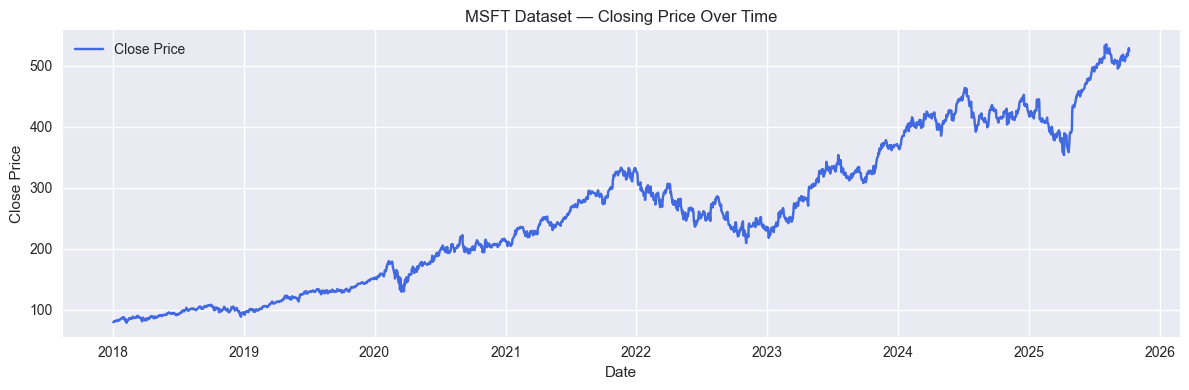

<Figure size 1000x400 with 0 Axes>

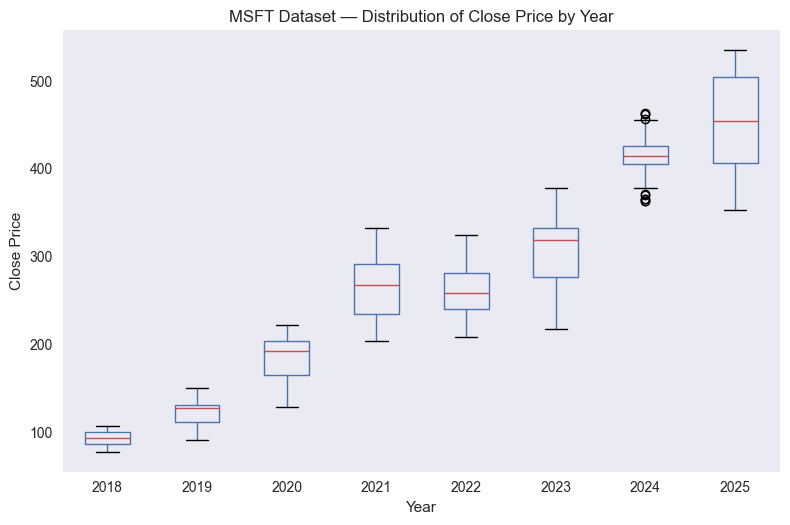

Clean dataset saved to: data/msft_cleaned.csv


,date,close,high,low,open,volume
0,2018-01-02,79.198341,79.530063,78.783693,79.364202,22483800
1,2018-01-03,79.566910,79.714345,79.216763,79.299689,26061400
2,2018-01-04,80.267204,80.774003,79.769622,79.788048,21912000
3,2018-01-05,81.262360,81.465079,80.562058,80.773994,23407100
4,2018-01-08,81.345306,81.621743,80.718722,81.271589,22113000


In [4]:
download_path = download_dataset(DATASET_ID)
raw_csv_path = select_csv_file(download_path, SEARCH_TERMS)
raw_df = pd.read_csv(raw_csv_path)

standardized_df = standardize_columns(raw_df)
clean_df = clean_dataframe(standardized_df, start_date=START_DATE, end_date=END_DATE)
summary = summarize_dataframe(clean_df)

plot_dataset(clean_df, title=f"{SEARCH_TERMS[0].upper()} Dataset")
export_dataframe(clean_df, OUTPUT_PATH)
clean_df.head()
